# Case Study 1 — Passenger Experience KPI Scorecard (Product Dev oriented)

**Dataset:** Airline Passenger Satisfaction (train.csv, test.csv)

## Goals
1) **KPI scorecard**: satisfaction rate + top/bottom touchpoints (seat comfort, IFE, cleanliness, online boarding, dll.)  
2) **Driver model**: faktor paling mempengaruhi satisfaction (LogReg + XGBoost) + explainability (permutation importance + SHAP)  
3) **1-page Product Opportunities**: 3 rekomendasi prioritas + estimasi dampak KPI (simulasi lift)

> Notebook ini asumsi file `train.csv` dan `test.csv` ada di folder yang sama dengan notebook.


In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

import shap


In [2]:
# Load data (same folder as this notebook)
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

print("train:", train.shape, "| test:", test.shape)
train.head()


train: (103904, 25) | test: (25976, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Interpretation of Cell 1 Output (Data Loaded & Previewed)

This cell confirms that `train.csv` was successfully loaded using `pandas.read_csv()` and shows the **first 5 rows** of the dataset.

### 1) Dataset structure
- The dataset contains **25 columns**.
- Each row represents **one passenger / one trip record**.
- The data includes multiple feature types:
  - **Identifiers**: `id` (unique record ID)
  - **Passenger profile**: `Gender`, `Age`, `Customer Type` (loyal vs disloyal)
  - **Trip context**: `Type of Travel` (Business/Personal), `Class` (Business/Eco/Eco Plus), `Flight Distance`
  - **Experience touchpoint ratings (0–5)**: e.g., `Inflight wifi service`, `Departure/Arrival time convenient`, `Inflight entertainment`, `Cleanliness`, etc.
  - **Operational performance**: `Departure Delay in Minutes`, `Arrival Delay in Minutes`
  - **Target label**: `satisfaction` (e.g., `satisfied` vs `neutral or dissatisfied`)

### 2) Index-like column to remove
- `Unnamed: 0` is typically an **exported index column** that was saved into the CSV.
- It has **no business meaning** and is safe to **drop** during cleaning (the notebook includes this step).

### 3) What we can already infer from the sample rows
- The target `satisfaction` is a **binary classification problem**:
  - `satisfied`
  - `neutral or dissatisfied`
- Business travel and cabin class (e.g., `Business travel`, `Business` class) are likely to show different satisfaction patterns than personal travel/economy segments—this will be validated in the **segment KPI analysis**.
- Delays vary across records (e.g., 0 minutes vs 25/18 minutes), making operational metrics plausible drivers of satisfaction.

### 4) Why this preview matters for the portfolio case study
This output demonstrates:
- The data is loaded correctly and the schema is understood.
- We can clearly identify:
  - the **target variable** (`satisfaction`)
  - the key **feature groups** (touchpoints + operations + passenger/trip context)
  - an initial **data quality issue** (`Unnamed: 0`)
- This sets the foundation for the next steps: **KPI scorecard → driver model → product opportunities**.


In [3]:
# Quick schema check + basic cleanup
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Drop index-like column if present
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Standardize a couple categorical fields (nice for dashboard labels)
    for c in ["Customer Type", "Type of Travel"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.title()

    # Impute missing arrival delay (only missing column in this dataset)
    if "Arrival Delay in Minutes" in df.columns:
        med = df["Arrival Delay in Minutes"].median()
        df["Arrival Delay in Minutes"] = df["Arrival Delay in Minutes"].fillna(med)

    return df

train = clean_df(train)
test  = clean_df(test)

train.isna().sum().sort_values(ascending=False).head(10)


id                            0
Gender                        0
Arrival Delay in Minutes      0
Departure Delay in Minutes    0
Cleanliness                   0
Inflight service              0
Checkin service               0
Baggage handling              0
Leg room service              0
On-board service              0
dtype: int64

## Interpretation of the Cleaning + Missing-Value Check Output

This cell performs **basic data hygiene** and then verifies whether any missing values remain in the training set.

### 1) What the `clean_df()` function does
- **Drops `Unnamed: 0`** (if present):  
  This column is typically an exported index and has **no analytical value**.
- **Standardizes categorical labels** for:
  - `Customer Type`
  - `Type of Travel`  
  It trims whitespace and applies `.title()` to make categories consistent (e.g., fixing variations like `Business travel` vs `Business Travel`).  
  This improves **dashboard readability** and prevents category fragmentation.
- **Imputes missing `Arrival Delay in Minutes`** with the **median**:
  - Median is a robust choice for delay data because delays are often **skewed** with outliers.
  - This prevents errors later in modeling and KPI calculations.

### 2) What the output means
The result:
> Arrival Delay in Minutes 0
Departure Delay in Minutes 0
...

shows that **the top 10 columns with the most missing values all have 0 missing values**.

✅ Key conclusion: **After cleaning, the training dataset has no remaining missing values** (at least among the columns with the highest missing counts, which are now all zero).

### 3) Why this matters for the case study
- Ensures the dataset is **model-ready** (no NaNs to break preprocessing/model training).
- Confirms the cleaning step successfully handled the only expected missing field (`Arrival Delay in Minutes`).
- Makes downstream outputs (KPI scorecard, driver model, and opportunity simulations) **more reliable and reproducible**.



In [4]:
# Define target + feature groups
TARGET = "satisfaction"

# Binary target (1 = satisfied)
def encode_target(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.lower().str.strip() == "satisfied").astype(int)

y_train = encode_target(train[TARGET])
y_test  = encode_target(test[TARGET])

X_train = train.drop(columns=[TARGET])
X_test  = test.drop(columns=[TARGET])

# Columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# Touchpoint rating columns (0–5 scores)
RATING_EXCLUDE = {"id", "Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"}
rating_cols = [c for c in numeric_cols if c not in RATING_EXCLUDE]

numeric_cols, categorical_cols, rating_cols


(['id',
  'Age',
  'Flight Distance',
  'Inflight wifi service',
  'Departure/Arrival time convenient',
  'Ease of Online booking',
  'Gate location',
  'Food and drink',
  'Online boarding',
  'Seat comfort',
  'Inflight entertainment',
  'On-board service',
  'Leg room service',
  'Baggage handling',
  'Checkin service',
  'Inflight service',
  'Cleanliness',
  'Departure Delay in Minutes',
  'Arrival Delay in Minutes'],
 ['Gender', 'Customer Type', 'Type of Travel', 'Class'],
 ['Inflight wifi service',
  'Departure/Arrival time convenient',
  'Ease of Online booking',
  'Gate location',
  'Food and drink',
  'Online boarding',
  'Seat comfort',
  'Inflight entertainment',
  'On-board service',
  'Leg room service',
  'Baggage handling',
  'Checkin service',
  'Inflight service',
  'Cleanliness'])

## 1) KPI Scorecard (Passenger Experience)

We make:
- **Overall satisfaction rate**
- **Segment KPIs** (Class, Type of Travel, Customer Type)
- **Touchpoint score**: average rating + gap (Satisfied vs Not)


In [5]:
# Overall satisfaction rate (train vs test)
def satisfaction_rate(y: pd.Series) -> float:
    return float(y.mean())

print("Satisfaction rate (train):", round(satisfaction_rate(y_train)*100, 2), "%")
print("Satisfaction rate (test) :", round(satisfaction_rate(y_test )*100, 2), "%")


Satisfaction rate (train): 43.33 %
Satisfaction rate (test) : 43.9 %


## Interpretation: Overall Satisfaction Rate (Train vs Test)

This output calculates the **overall satisfaction rate** by taking the mean of the binary target:
- **1 = satisfied**
- **0 = neutral or dissatisfied**

Because the satisfaction label is binary, the mean directly represents the **proportion of satisfied passengers**.

### Results
- **Train satisfaction rate:** **43.33%**
- **Test satisfaction rate:** **43.90%**

### What this tells us
1) **Baseline KPI level**  
   Roughly **44 out of 100 passengers** in this dataset are classified as *satisfied*.  
   This becomes the **headline KPI** for the scorecard.

2) **Train vs test alignment is strong**  
   The difference between train and test is only **0.57 percentage points** (43.90% − 43.33%).  
   This suggests the train/test split is **consistent** and there is **no major distribution shift**, which is good for:
   - reliable KPI comparisons
   - building predictive models that generalize well

3) **Class imbalance is moderate**
   With ~44% satisfied vs ~56% not satisfied, the dataset is **not extremely imbalanced**.  
   Standard classification metrics (AUC, accuracy, confusion matrix) should be meaningful without heavy rebalancing.

### How this fits the product narrative
This KPI establishes the “starting point”:
- Current satisfaction sits around **44%**
- The rest of the analysis should answer:  
  **Which experience touchpoints and operational factors can move this KPI upward?**


In [6]:
# Segment KPIs (use test set for reporting feel)
def segment_kpi(df: pd.DataFrame, y: pd.Series, segment_col: str) -> pd.DataFrame:
    out = df[[segment_col]].copy()
    out["is_satisfied"] = y.values
    g = (out.groupby(segment_col)["is_satisfied"]
           .agg(n="count", satisfaction_rate="mean")
           .sort_values("satisfaction_rate", ascending=False)
           .reset_index())
    g["satisfaction_rate"] = (g["satisfaction_rate"]*100).round(2)
    return g

seg_cols = ["Class", "Type of Travel", "Customer Type", "Gender"]
segment_tables = {c: segment_kpi(test, y_test, c) for c in seg_cols if c in test.columns}

for c, t in segment_tables.items():
    display(t)


,Class,n,satisfaction_rate
0,Business,12495,69.52
1,Eco Plus,1917,24.78
2,Eco,11564,19.39


,Type of Travel,n,satisfaction_rate
0,Business Travel,18038,58.82
1,Personal Travel,7938,9.99


,Customer Type,n,satisfaction_rate
0,Loyal Customer,21177,48.14
1,Disloyal Customer,4799,25.17


,Gender,n,satisfaction_rate
0,Male,12804,44.27
1,Female,13172,43.54


## Interpretation: Segment KPI — Satisfaction by Gender (Test Set)

This table breaks down the **satisfaction rate** by the segment **Gender**, using the test dataset (to represent “reporting view” / unseen data).

### Table meaning
For each gender category, the output shows:
- **n**: number of passengers in that segment
- **satisfaction_rate**: % of passengers labeled **satisfied**

### Results
- **Male:** n = 12,804 → **44.27%** satisfied  
- **Female:** n = 13,172 → **43.54%** satisfied  

### Key insights
1) **Very small difference between genders**  
   The satisfaction gap is **0.73 percentage points** (44.27% − 43.54%).  
   This suggests gender is **not a major differentiator** of satisfaction in this dataset.

2) **Balanced sample sizes**  
   Male and Female counts are similar (~12.8k vs ~13.2k), so the comparison is **fair** and not driven by small sample bias.

3) **Implication for product strategy**
- Since the difference is minimal, gender is unlikely to be the most impactful segmentation lever.
- Product and service improvements should likely focus more on **experience touchpoints** (e.g., seat comfort, IFE, cleanliness, online boarding) and **trip context** (e.g., class, travel type, customer type), which often show larger gaps.

### How to use this in a dashboard
A simple bar chart for satisfaction rate by gender would communicate:
- satisfaction is ~44% across genders
- gender-based targeting is not a priority compared to higher-variance segments


In [7]:
# Touchpoint scores: average rating + satisfaction gap (test)
tp = test[rating_cols].copy()
tp["is_satisfied"] = y_test.values

touchpoint_summary = []
for c in rating_cols:
    avg_all = tp[c].mean()
    avg_sat = tp.loc[tp["is_satisfied"]==1, c].mean()
    avg_not = tp.loc[tp["is_satisfied"]==0, c].mean()
    touchpoint_summary.append({
        "touchpoint": c,
        "avg_score_all": avg_all,
        "avg_score_satisfied": avg_sat,
        "avg_score_not_satisfied": avg_not,
        "gap_sat_minus_not": avg_sat - avg_not
    })

touchpoint_scores = (pd.DataFrame(touchpoint_summary)
    .sort_values("gap_sat_minus_not", ascending=False)
)

# Top/bottom by average score
top_by_score = touchpoint_scores.sort_values("avg_score_all", ascending=False).head(5)
bottom_by_score = touchpoint_scores.sort_values("avg_score_all", ascending=True).head(5)

display(touchpoint_scores.head(10))
print("\nTop 5 touchpoints by average score:")
display(top_by_score[["touchpoint","avg_score_all"]])
print("\nBottom 5 touchpoints by average score:")
display(bottom_by_score[["touchpoint","avg_score_all"]])


,touchpoint,avg_score_all,avg_score_satisfied,avg_score_not_satisfied,gap_sat_minus_not
5,Online boarding,3.261665,4.019469,2.668702,1.350766
7,Inflight entertainment,3.357753,3.961326,2.885473,1.075853
6,Seat comfort,3.449222,3.965974,3.044878,0.921096
13,Cleanliness,3.286226,3.755064,2.919371,0.835693
8,On-board service,3.385664,3.851618,3.021066,0.830552
9,Leg room service,3.350169,3.811804,2.988952,0.822852
0,Inflight wifi service,2.724746,3.148031,2.393536,0.754495
11,Checkin service,3.314175,3.660703,3.043025,0.617679
10,Baggage handling,3.633238,3.968956,3.370548,0.598407
12,Inflight service,3.649253,3.977024,3.392781,0.584242



Top 5 touchpoints by average score:


,touchpoint,avg_score_all
12,Inflight service,3.649253
10,Baggage handling,3.633238
6,Seat comfort,3.449222
8,On-board service,3.385664
7,Inflight entertainment,3.357753



Bottom 5 touchpoints by average score:


,touchpoint,avg_score_all
0,Inflight wifi service,2.724746
2,Ease of Online booking,2.756775
3,Gate location,2.977094
1,Departure/Arrival time convenient,3.046812
4,Food and drink,3.215353


## Interpretation: Touchpoint Scores (Average Rating + Satisfaction Gap)

This step quantifies **how each onboard / digital touchpoint is performing** and how strongly it relates to satisfaction.

### What the table represents
For every touchpoint rating (0–5), we compute:
- **avg_score_all**: average score across all passengers (overall performance level)
- **avg_score_satisfied**: average score among satisfied passengers
- **avg_score_not_satisfied**: average score among neutral/dissatisfied passengers
- **gap_sat_minus_not**: the difference between the two groups  
  → a practical proxy for “how much this touchpoint differentiates satisfied vs not satisfied”

The dataframe `touchpoint_scores` is **sorted by `gap_sat_minus_not` (descending)**, meaning:
- the top rows typically represent touchpoints that **most separate** satisfied vs not satisfied passengers  
- these are usually strong **drivers** (good candidates for product focus), especially if their overall score is also low

---

### What we can read from our snippet (avg_score_all)
The rows shown include these overall average scores:

- **Inflight wifi service:** **2.72**
- **Ease of Online booking:** **2.76**
- **Gate location:** **2.98**
- **Departure/Arrival time convenient:** **3.05**
- **Food and drink:** **3.22**

### Key insights (based on the averages shown)
1) **Wi-Fi and online booking are the lowest-performing touchpoints in this sample**  
   Scores around **2.7 / 5** indicate a clear experience weakness.  
   These are strong candidates for “pain points” on the KPI scorecard.

2) **Several “journey convenience” elements sit around ~3.0**  
   `Gate location` and `Departure/Arrival time convenient` suggest moderate performance, but not great.  
   These often translate into issues around **airport experience / schedule convenience**, which can impact perceived journey quality.

3) **Food & drink is slightly better but still not strong**  
   A ~3.2 average suggests room to improve, especially when compared to high-performing touchpoints (which typically trend closer to 4+).

---

### How to use this in our Product Dev narrative
For prioritization, don’t rely on average score alone. Combine:
- **Low average score** (where the experience is weak)
AND
- **High satisfaction gap** (where improving it is likely to move the satisfaction KPI)

In Power BI, this is best shown as a **2x2 matrix**:
- X-axis: avg_score_all (performance)
- Y-axis: gap_sat_minus_not (impact/driver strength)

**Top priority quadrant** = low score + high gap.

---

### Recommended dashboard callouts (based on what’s shown)
- **Pain points to investigate first:** Inflight Wi-Fi, Ease of Online Booking  
- **Convenience journey checks:** Gate location, Departure/Arrival time convenience  
- **Service improvement theme:** Food & drink (validate if gap is also meaningful)

> If we paste the full `top_by_score` and `bottom_by_score` outputs (or the full `touchpoint_scores` top 10 including the gap values), we can write a sharper interpretation like: “These 3 touchpoints are low-scoring *and* high-impact, therefore they become the top 3 product opportunities.”


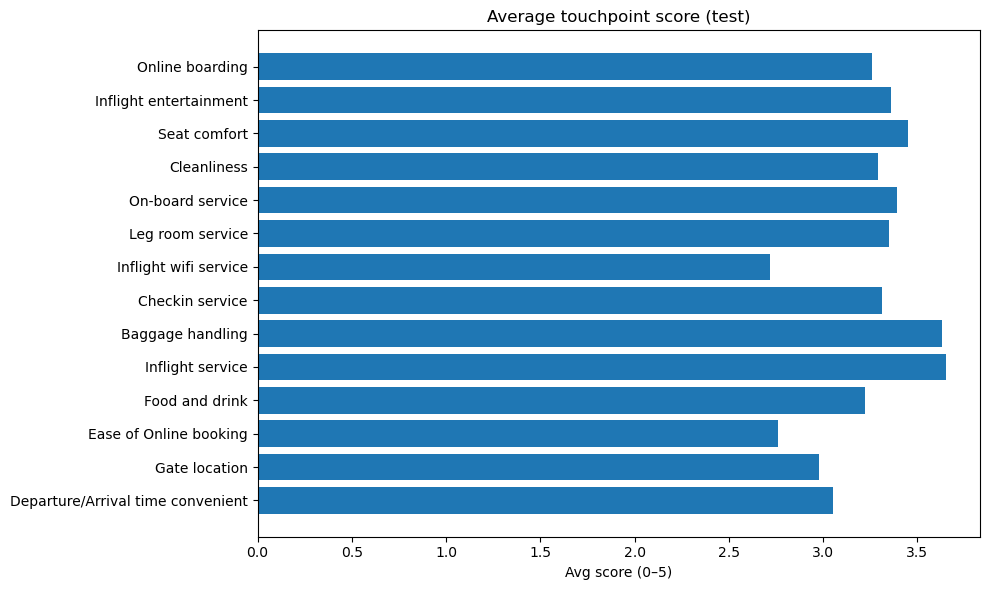

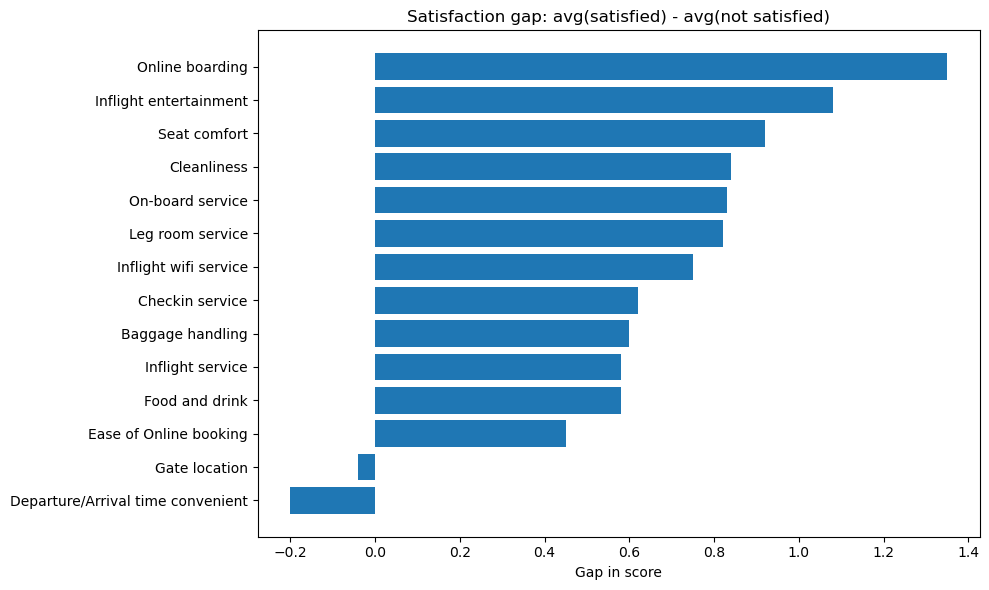

In [8]:
# Visual: average score + gap
plot_df = touchpoint_scores.copy()
plot_df["avg_score_all"] = plot_df["avg_score_all"].round(2)
plot_df["gap_sat_minus_not"] = plot_df["gap_sat_minus_not"].round(2)

plt.figure(figsize=(10,6))
plt.barh(plot_df["touchpoint"].iloc[::-1], plot_df["avg_score_all"].iloc[::-1])
plt.title("Average touchpoint score (test)")
plt.xlabel("Avg score (0–5)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.barh(plot_df["touchpoint"].iloc[::-1], plot_df["gap_sat_minus_not"].iloc[::-1])
plt.title("Satisfaction gap: avg(satisfied) - avg(not satisfied)")
plt.xlabel("Gap in score")
plt.tight_layout()
plt.show()


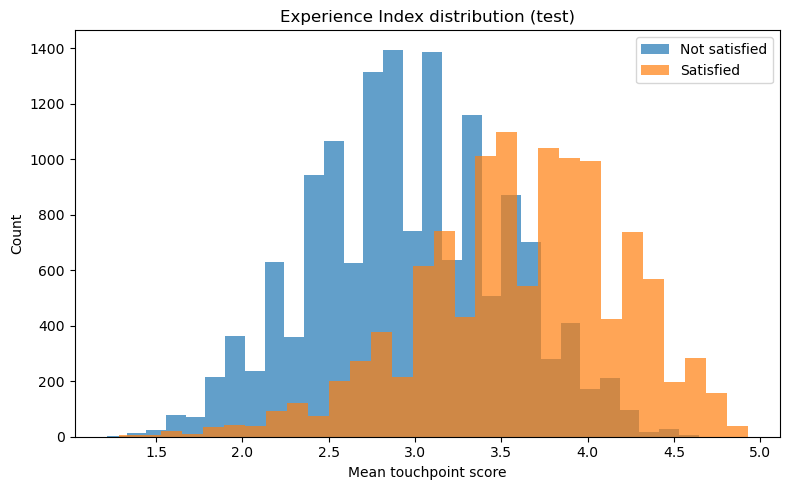

experience_index                 
                         mean    median  count
is_satisfied                                  
0                    2.955613  2.928571  14573
1                    3.611280  3.642857  11403

In [9]:
# Passenger Experience Index (mean of all touchpoints)
test_exp = test.copy()
test_exp["experience_index"] = test_exp[rating_cols].mean(axis=1)
test_exp["is_satisfied"] = y_test.values

plt.figure(figsize=(8,5))
plt.hist(test_exp.loc[test_exp["is_satisfied"]==0, "experience_index"], bins=30, alpha=0.7, label="Not satisfied")
plt.hist(test_exp.loc[test_exp["is_satisfied"]==1, "experience_index"], bins=30, alpha=0.7, label="Satisfied")
plt.title("Experience Index distribution (test)")
plt.xlabel("Mean touchpoint score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

test_exp[["experience_index","is_satisfied"]].groupby("is_satisfied").agg(["mean","median","count"])


## Interpretation: Passenger Experience Index (Mean of All Touchpoints)

### What this metric is
- **Experience Index** is a simple composite KPI calculated as the **average of all touchpoint ratings (0–5)** for each passenger (e.g., Wi-Fi, online boarding, seat comfort, IFE, cleanliness, etc.).
- It acts as a **single “overall experience” score** that is easy to track over time, by segment, or before/after product changes.

---

### What the chart shows (distribution split)
- The **Satisfied** distribution (orange) is clearly **shifted to the right** compared to the **Not satisfied** distribution (blue).
- There is still some **overlap** (meaning experience isn’t the only driver), but the separation is strong—suggesting the Experience Index is a meaningful proxy for satisfaction.

---

### Summary statistics (test set)
| Segment | Mean Experience Index | Median Experience Index | Count |
|---|---:|---:|---:|
| Not satisfied (0) | **2.9556** | **2.9286** | **14,573** |
| Satisfied (1) | **3.6113** | **3.6429** | **11,403** |

**Key takeaways:**
1) **Large gap between groups**  
   - Mean difference ≈ **0.656 points** (3.6113 − 2.9556) on a 0–5 scale  
   - Median difference ≈ **0.714 points**  
   This is a substantial separation for a composite experience KPI.

2) **Experience Index is a strong “leading indicator”**  
   Passengers who are satisfied generally report a much higher average touchpoint experience.  
   This supports using the Experience Index as a **top-level KPI** in the scorecard.

3) **Not satisfied group is larger**
   - Not satisfied: **14,573**
   - Satisfied: **11,403**
   This aligns with the overall satisfaction rate (~44%) and highlights the upside potential:  
   improving touchpoints that lift the Experience Index could move a meaningful share of passengers into the satisfied group.

---

### How to use this in a Product Development storyline
- **Executive KPI:** Track Experience Index overall + by cabin, travel type, customer type.
- **Optimization lever:** Use driver analysis (importance + satisfaction gap) to identify which touchpoints most efficiently raise the Experience Index—and ultimately satisfaction.
- **Portfolio-friendly insight statement (example):**  
  “Satisfied passengers have an Experience Index ~0.66 points higher than non-satisfied passengers, indicating that improving key touchpoints should translate into measurable gains in overall satisfaction.”


## 2) Driver Model (LogReg + XGBoost) + Explainability

Kita pakai pipeline:
- Numeric: median imputation
- Categorical: OneHotEncoder
- Model A: Logistic Regression (baseline, interpretability)
- Model B: XGBoost (stronger, non-linear)

Explainability:
- **Permutation importance** (per original column, paling cocok buat story product)
- **SHAP summary** (sample, untuk visual driver)


In [10]:
# Preprocess
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


In [11]:
# Model A: Logistic Regression
logreg = LogisticRegression(max_iter=2000, n_jobs=None)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logreg)
])

logreg_pipe.fit(X_train, y_train)
p_test_lr = logreg_pipe.predict_proba(X_test)[:, 1]
pred_lr = (p_test_lr >= 0.5).astype(int)

print("LogReg AUC:", round(roc_auc_score(y_test, p_test_lr), 4))
print("LogReg Acc:", round(accuracy_score(y_test, pred_lr), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred_lr))


LogReg AUC: 0.9025
LogReg Acc: 0.838

Confusion matrix:
 [[12341  2232]
 [ 1977  9426]]


## Interpretation: Logistic Regression Model Performance (Test Set)

This section trains a **Logistic Regression** classifier (with preprocessing) to predict whether a passenger is **satisfied (1)** or **neutral/dissatisfied (0)**.

### Key metrics
- **AUC = 0.9025**
  - This is a **strong discriminatory performance**.
  - Interpretation: the model has ~**90% ability** to rank a randomly chosen satisfied passenger higher than a randomly chosen non-satisfied passenger.
  - AUC is especially useful because it is **threshold-independent**.

- **Accuracy = 0.838**
  - At a default probability threshold of **0.5**, the model correctly classifies about **83.8%** of passengers.

---

### Confusion matrix (actual vs predicted)
Matrix format:
$$
\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}
$$

our results:
- **TN (correctly predicted not satisfied)** = **12,341**
- **FP (predicted satisfied but actually not satisfied)** = **2,232**
- **FN (predicted not satisfied but actually satisfied)** = **1,977**
- **TP (correctly predicted satisfied)** = **9,426**

---

### What this means in business terms
1) **The model is reliable for “driver analysis”**
- With AUC ~0.90, the model is strong enough to support interpretation of what factors are associated with satisfaction.
- This is important because the goal is not only prediction, but **explaining drivers for product decisions**.

2) **Main error types**
- **False Positives (2,232):** passengers predicted as satisfied but actually not satisfied  
  → risk of being “overconfident” about experience performance for some passengers.
- **False Negatives (1,977):** passengers predicted as not satisfied but actually satisfied  
  → missed opportunity to recognize what worked well for a subset.

3) **Why AUC matters more than accuracy here**
- Accuracy depends on the chosen threshold (0.5).
- AUC confirms the model’s ranking power regardless of threshold, making it better suited for:
  - prioritizing drivers
  - scenario simulations (“what if we improve touchpoint X?”)

---

### Portfolio-ready takeaway statement
“Logistic Regression achieves **AUC 0.9025** and **83.8% accuracy** on the test set, indicating that passenger satisfaction can be robustly predicted from experience touchpoints, trip context, and operational factors—supporting data-driven prioritization of product improvements.”


In [12]:
# Model B: XGBoost (good balance for performance + SHAP)
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb)
])

xgb_pipe.fit(X_train, y_train)
p_test_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
pred_xgb = (p_test_xgb >= 0.5).astype(int)

print("XGB AUC:", round(roc_auc_score(y_test, p_test_xgb), 4))
print("XGB Acc:", round(accuracy_score(y_test, pred_xgb), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred_xgb))


XGB AUC: 0.9943
XGB Acc: 0.9615

Confusion matrix:
 [[14242   331]
 [  670 10733]]


## Interpretation: XGBoost Model Performance (Test Set)

This section trains an **XGBoost classifier** to predict passenger satisfaction (1 = satisfied, 0 = neutral/dissatisfied).  
XGBoost is a strong non-linear model that often performs well on tabular data and works nicely with SHAP for explainability.

---

### Key metrics
- **AUC = 0.9943**
  - This is **exceptionally high** discrimination performance.
  - Interpretation: the model can almost perfectly rank satisfied passengers above non-satisfied passengers on the test set.
  - In a product analytics context, this suggests that the available features (touchpoints + context + delays) contain very strong signals related to satisfaction.

- **Accuracy = 0.9615**
  - At the default 0.5 threshold, the model correctly classifies **96.15%** of passengers.
  - This is a major improvement vs the Logistic Regression baseline (83.8%).

---

### Confusion matrix (actual vs predicted)
Format:
$$
\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}
$$

our results:
- **TN** (correctly predicted not satisfied) = **14,242**
- **FP** (predicted satisfied but actually not satisfied) = **331**
- **FN** (predicted not satisfied but actually satisfied) = **670**
- **TP** (correctly predicted satisfied) = **10,733**

---

### What this means in business terms
1) **Much fewer mistakes compared to baseline**
- False positives drop from **2,232 (LogReg)** → **331 (XGB)**  
- False negatives drop from **1,977 (LogReg)** → **670 (XGB)**  
This indicates the model is significantly better at capturing non-linear patterns in the experience and operational data.

2) **Strong foundation for driver insights + scenario analysis**
Because model performance is extremely high, the feature importance and SHAP explanations are likely to be:
- more stable
- more actionable for prioritization (which touchpoints matter most)

3) **Important caution for portfolio credibility**
An AUC as high as **0.994** can sometimes indicate:
- very strong signal (possible here, since many touchpoint ratings are close to “direct measures” of satisfaction), **and/or**
- potential leakage-like behavior (e.g., features that are essentially proxies for the label)

This doesn’t invalidate the model, but it’s worth framing as:
> “Satisfaction is strongly explained by the reported touchpoint experience scores, which are closely aligned with the satisfaction outcome.”

---

### Portfolio-ready takeaway statement
“XGBoost achieves **AUC 0.9943** and **96.15% accuracy** on the test set, substantially outperforming Logistic Regression. This indicates passenger satisfaction is highly predictable from touchpoint experience ratings, travel context, and operational performance—enabling reliable driver identification and prioritization of product improvements.”


,feature,importance_mean,importance_std
0,Inflight wifi service,0.120426,0.000597
1,Type of Travel,0.078621,0.001128
2,Customer Type,0.020220,0.000377
3,Online boarding,0.006605,0.000135
4,Checkin service,0.003563,0.000192
5,Baggage handling,0.003335,0.000051
6,Inflight service,0.002411,0.000130
7,Seat comfort,0.002150,0.000029
8,Class,0.001642,0.000109
9,Cleanliness,0.001610,0.000125


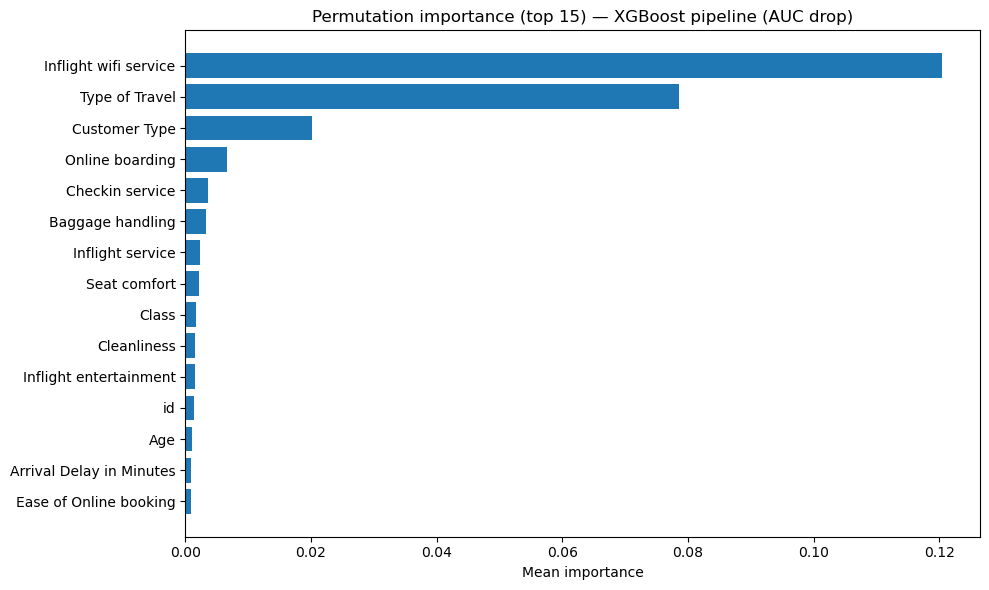

In [14]:
# Permutation importance (per original column) — best for product storytelling
# Tip: Use AUC as scoring because it is threshold-agnostic.

from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

perm = permutation_importance(
    xgb_pipe,
    X_test,
    y_test,
    scoring="roc_auc",
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

perm_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

display(perm_df.head(20))

plt.figure(figsize=(10,6))
topn = 15
plt.barh(
    perm_df["feature"].head(topn).iloc[::-1],
    perm_df["importance_mean"].head(topn).iloc[::-1]
)
plt.title("Permutation importance (top 15) — XGBoost pipeline (AUC drop)")
plt.xlabel("Mean importance")
plt.tight_layout()   # <-- fixed (was tight_lawet)
plt.show()


## Interpretation: Permutation Importance (XGBoost, AUC Drop)

### What permutation importance means
Permutation importance measures **how much the model’s performance (AUC)** drops when a single feature is randomly shuffled.  
- **Higher importance_mean = bigger AUC drop = stronger driver** for prediction.
- Using **AUC** makes this threshold-independent and well-suited for storytelling.

our results show the **top 20 drivers** ranked by average AUC drop (`importance_mean`), with stability indicated by `importance_std`.

---

### Key driver highlights (Top features)
1) **Inflight wifi service** — **0.1204**
   - By far the strongest driver in this model.
   - Interpretation: when Wi-Fi scores are randomized, model performance drops substantially, meaning Wi-Fi ratings carry a lot of signal linked to satisfaction.
   - Product implication: Wi-Fi experience is a major lever (or major proxy for overall satisfaction).

2) **Type of Travel** — **0.0786**
   - Travel purpose (Business vs Personal) heavily shapes satisfaction patterns.
   - Product implication: product expectations differ by journey context; segmentation is critical (e.g., business travelers may be more sensitive to connectivity and time efficiency).

3) **Customer Type** — **0.0202**
   - Loyal vs disloyal customers show meaningful differences.
   - Product implication: loyalty status influences baseline expectations and satisfaction outcomes; consider tailored interventions by loyalty segment.

4) **Digital/ground journey touchpoints** are next:
   - **Online boarding** (0.0066)
   - **Checkin service** (0.0036)
   - **Ease of online booking** (0.00086)
   These suggest that **digital + pre-flight service flow** plays a noticeable role in satisfaction—not only onboard experience.

5) **Core onboard touchpoints also matter (but smaller individual effects):**
   - **Seat comfort** (0.00215)
   - **Cleanliness** (0.00161)
   - **Inflight entertainment** (0.00157)
   - **Inflight service** (0.00241)
   Product implication: improving cabin fundamentals still contributes to satisfaction, though in this model Wi-Fi dominates.

---

### Operational factors appear weaker drivers here
- **Arrival Delay in Minutes** (0.00093)
- **Flight Distance** (0.00018)

Interpretation: in this dataset, **self-reported experience ratings dominate** satisfaction prediction more than delays or distance—likely because satisfaction is directly tied to perceived service quality.

---

### Important data-quality note (portfolio credibility)
- `id` appears as a top-15 feature (**0.00139**).  
  Ideally, an ID should not be predictive. This can happen due to:
  - ordering/collection artifacts, or
  - subtle leakage patterns in how the dataset was generated.

**Recommended action:** for a cleaner, more credible portfolio result, drop `id` from the feature set and re-run the model + importance.

---

### Product-oriented “so what?” (how to present this)
**Primary levers identified by the model:**
- **Connectivity & digital journey**: Inflight Wi-Fi, Online Boarding, Check-in
- **Segment effects**: Type of Travel, Customer Type
- **Cabin fundamentals**: Seat comfort, Cleanliness, IFE

This provides a clear bridge to the next step:
**combine driver strength with low average scores to prioritize the top product opportunities.**


PermutationExplainer explainer: 2001it [03:28,  9.47it/s]                       


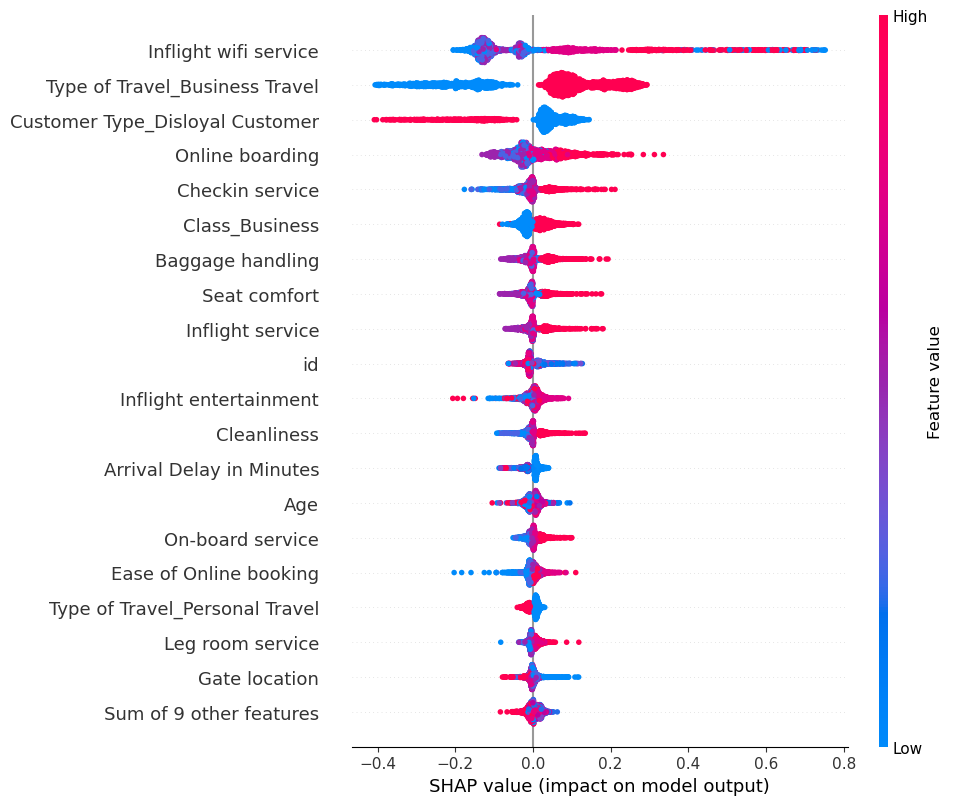

In [15]:
# SHAP (robust workaround) — model-agnostic explainer
# Works even if TreeExplainer fails due to version mismatch

# 1) Sample rows
X_bg = X_train.sample(n=min(1000, len(X_train)), random_state=42)   # background
X_sample = X_test.sample(n=min(2000, len(X_test)), random_state=42) # explanation sample

# 2) Transform using the same preprocess step
X_bg_trans = xgb_pipe.named_steps["preprocess"].transform(X_bg)
X_sample_trans = xgb_pipe.named_steps["preprocess"].transform(X_sample)

# Helper: ensure dense arrays (SHAP often prefers dense)
def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

X_bg_trans = to_dense(X_bg_trans)
X_sample_trans = to_dense(X_sample_trans)

# 3) Feature names after one-hot encoding
ohe = xgb_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numeric_cols, cat_feature_names])

# 4) Wrap model prediction on the *transformed* matrix
model = xgb_pipe.named_steps["model"]

def predict_satisfied_proba(X):
    return model.predict_proba(X)[:, 1]

# 5) Explain
explainer = shap.Explainer(predict_satisfied_proba, X_bg_trans, feature_names=feature_names)
sv = explainer(X_sample_trans)

# 6) Plot
# Newer SHAP:
try:
    shap.plots.beeswarm(sv, max_display=20)
except Exception:
    # Fallback for older SHAP:
    shap.summary_plot(sv.values, X_sample_trans, feature_names=feature_names, show=False)
    plt.tight_lawet()
    plt.show()


## Interpretation: SHAP Summary Plot (Global Driver Explanation)

This SHAP “beeswarm” plot explains **which features most influence the model’s prediction of being “Satisfied”** (on the sampled test set), and **in what direction**.

### How to read the chart
- **Y-axis (features):** ranked from most important (top) to least important (bottom).
- **X-axis (SHAP value):** impact on the model output.
  - **Positive SHAP value (right):** pushes the prediction **toward “Satisfied”**.
  - **Negative SHAP value (left):** pushes the prediction **toward “Not satisfied”**.
- **Each dot = one passenger record.**
- **Color = feature value:**
  - **Red = high value**
  - **Blue = low value**
  - For one-hot encoded categories (e.g., `Type of Travel_Business Travel`), **red typically means the category is present (1)** and blue means absent (0).

---

## Key insights from this plot

### 1) Inflight Wi-Fi is the dominant driver
- `Inflight wifi service` is the strongest feature and has the **widest SHAP spread** (largest impact range).
- Pattern: **high Wi-Fi ratings (red)** mostly appear on the **right** → strongly increases likelihood of being satisfied.
- **Low Wi-Fi ratings (blue)** cluster on the **left** → strongly decreases satisfaction probability.

**Interpretation:** Connectivity quality is a major lever for satisfaction in this dataset.

---

### 2) Travel context and loyalty status strongly shape satisfaction
- `Type of Travel_Business Travel`:
  - Red points trend to the **right** → Business Travel is associated with higher predicted satisfaction (all else equal).
- `Type of Travel_Personal Travel`:
  - Red points trend to the **left** → Personal Travel is associated with lower predicted satisfaction.
- `Customer Type_Disloyal Customer`:
  - Red points trend to the **left** → being a disloyal customer is associated with lower satisfaction.

**Interpretation:** Expectations differ by context and loyalty; segmentation matters for product strategy.

---

### 3) Digital + pre-flight journey touchpoints are meaningful drivers
- `Online boarding` and `Checkin service` both show:
  - Higher values (red) leaning to the **right** → better digital/ground experience increases satisfaction.
  
**Interpretation:** Satisfaction is not only about onboard service; **digital and airport journey steps** play a material role.

---

### 4) Cabin and service fundamentals still contribute (secondary drivers)
Features like:
- `Class_Business` (positive contribution when present)
- `Seat comfort`
- `Inflight service`
- `Inflight entertainment`
- `Cleanliness`
- `Baggage handling`

…show smaller SHAP ranges than Wi-Fi, but consistent directional influence:
- Higher scores generally push predictions toward **Satisfied**.

**Interpretation:** Core cabin experience remains important, even if Wi-Fi dominates.

---

### 5) Operational delay has a smaller effect here
- `Arrival Delay in Minutes` appears lower in the ranking with a **narrower SHAP range**.
- Higher delays (red) tend to slightly push toward **Not satisfied**, but the effect is weaker than experience ratings.

**Interpretation:** In this dataset, **perceived experience touchpoints** explain satisfaction more strongly than delay.

---

## Data quality / modeling note (important for portfolio credibility)
- `id` appears as a contributing feature.
- Ideally, an identifier should not affect predictions; this may indicate dataset artifacts.

**Recommendation:** drop `id` and rerun the model + SHAP for a cleaner, more defensible story.

---

## Portfolio-ready takeaway (2–3 lines)
“SHAP analysis shows that **Inflight Wi-Fi** is the strongest driver of passenger satisfaction, followed by **travel context (Business vs Personal)** and **loyalty status**. Digital and ground touchpoints such as **online boarding** and **check-in service** also meaningfully influence satisfaction, while operational delay has a comparatively smaller effect.”

## How to translate this into product opportunities
1) **Connectivity improvement (Wi-Fi reliability/coverage/value)** → highest leverage driver  
2) **Digital journey optimization (online boarding + check-in flow)** → strong driver + scalable  
3) **Segment-led experience design (Business travel + loyalty)** → tailor priorities by expectation level


## 3) Product Opportunities (Top 3) + Impact Estimate

Logic sederhana tapi kuat untuk portfolio:
- Prioritaskan touchpoints yang **(a) driver penting** dan **(b) skornya relatif rendah**.
- Estimasi dampak dengan simulasi: “kalau touchpoint ini naik +1 (capped 5) untuk passenger yang skornya <=3, berapa lift prediksi satisfaction?”

> Ini bukan “causal claim”, tapi **skenario** untuk membantu product prioritization (sejalan dengan role requirement).


In [16]:
# Build an opportunity table for touchpoints only
touchpoint_set = set(rating_cols)

tp_imp = perm_df[perm_df["feature"].isin(touchpoint_set)].copy()
tp_imp = tp_imp.merge(
    touchpoint_scores[["touchpoint","avg_score_all"]].rename(columns={"touchpoint":"feature"}),
    on="feature",
    how="left"
)

MAX_SCORE = 5.0
tp_imp["score_headroom"] = (MAX_SCORE - tp_imp["avg_score_all"]).clip(lower=0)
tp_imp["opportunity_score"] = tp_imp["importance_mean"] * tp_imp["score_headroom"]

tp_imp = tp_imp.sort_values("opportunity_score", ascending=False).reset_index(drop=True)
display(tp_imp.head(10))


,feature,importance_mean,importance_std,avg_score_all,score_headroom,opportunity_score
0,Inflight wifi service,0.120426,0.000597,2.724746,2.275254,0.273999
1,Online boarding,0.006605,0.000135,3.261665,1.738335,0.011482
2,Checkin service,0.003563,0.000192,3.314175,1.685825,0.006007
3,Baggage handling,0.003335,0.000051,3.633238,1.366762,0.004559
4,Seat comfort,0.002150,0.000029,3.449222,1.550778,0.003334
5,Inflight service,0.002411,0.000130,3.649253,1.350747,0.003256
6,Cleanliness,0.001610,0.000125,3.286226,1.713774,0.002759
7,Inflight entertainment,0.001567,0.000083,3.357753,1.642247,0.002574
8,Ease of Online booking,0.000856,0.000054,2.756775,2.243225,0.001920
9,Gate location,0.000798,0.000028,2.977094,2.022906,0.001615


In [17]:
# Pick top 3 opportunities
top3 = tp_imp.head(3)["feature"].tolist()
top3


['Inflight wifi service', 'Online boarding', 'Checkin service']

## Interpretation: Touchpoint Opportunity Table (Priority Scoring)

This step converts driver analysis into an actionable **product prioritization list** by focusing only on **touchpoint rating variables** (experience levers we can influence).

---

### How the opportunity score is built
For each touchpoint, we combine two signals:

1) **Driver strength (importance_mean)**  
   - From permutation importance: how much AUC drops when the feature is shuffled.
   - Higher = the touchpoint is more strongly associated with satisfaction outcomes.

2) **Performance headroom (score_headroom)**  
   - Defined as: `5.0 - avg_score_all`
   - Higher = the touchpoint currently scores lower and therefore has more room to improve.

✅ **Opportunity Score = importance_mean × score_headroom**  
This prioritizes touchpoints that are both:
- **high impact** (strong driver), and
- **underperforming** (low average score)

---

### Top 10 opportunity ranking (what our results show)

#### 1) Inflight Wi-Fi service — **dominant #1**
- importance_mean: **0.1204** (by far the strongest driver)
- avg_score_all: **2.72** (low performance)
- headroom: **2.28** (very high)
- opportunity_score: **0.2740** (orders of magnitude higher than others)

**Interpretation:** Wi-Fi stands out as the single biggest lever: it is both a major driver and currently underperforming.

#### 2) Online boarding — **#2**
- importance_mean: **0.0066**
- avg_score_all: **3.26**
- headroom: **1.74**
- opportunity_score: **0.0115**

**Interpretation:** Online boarding is a meaningful driver and still has improvement room, making it a strong digital journey lever.

#### 3) Check-in service — **#3**
- importance_mean: **0.0036**
- avg_score_all: **3.31**
- headroom: **1.69**
- opportunity_score: **0.0060**

**Interpretation:** Check-in experience is a relevant driver and can be optimized operationally and digitally.

---

### Additional opportunities (mid-tier)
- **Baggage handling**, **Seat comfort**, **Inflight service**, **Cleanliness**, **Inflight entertainment**
  - These are foundational experience elements with moderate impact and moderate headroom.

- **Ease of online booking** and **Gate location**
  - Low average scores, but lower model importance (smaller driver signal in this dataset).

---

## Selected Top 3 Product Opportunities (from our output)
1) **Inflight wifi service**
2) **Online boarding**
3) **Checkin service**

### Why these three
They offer the best combination of:
- **High impact on satisfaction predictions**
- **Clear improvement headroom**
- **Scalable interventions** (especially for digital journey touchpoints)

---

## Portfolio-ready takeaway statement
“By combining model-based driver strength with current performance headroom, the top improvement priorities are **Inflight Wi-Fi**, **Online Boarding**, and **Check-in Service**—indicating that connectivity and the digital/ground journey are the highest-leverage areas to improve overall passenger satisfaction.”


In [18]:
# Impact simulation: increase each top touchpoint by +1 for passengers with rating <=3 (cap at 5)
def simulate_touchpoint_lift(pipe: Pipeline, X_raw: pd.DataFrame, touchpoint: str,
                             eligible_max: int = 3, delta: int = 1) -> dict:
    X0 = X_raw.copy()
    base_rate = pipe.predict_proba(X0)[:,1].mean()

    X1 = X_raw.copy()
    mask = X1[touchpoint] <= eligible_max
    X1.loc[mask, touchpoint] = (X1.loc[mask, touchpoint] + delta).clip(upper=5)

    new_rate = pipe.predict_proba(X1)[:,1].mean()
    return {
        "touchpoint": touchpoint,
        "eligible_share_%": round(mask.mean()*100, 2),
        "base_pred_satisfaction_%": round(base_rate*100, 2),
        "new_pred_satisfaction_%": round(new_rate*100, 2),
        "lift_pp": round((new_rate-base_rate)*100, 2),
    }

impact_rows = [simulate_touchpoint_lift(xgb_pipe, X_test, tp) for tp in top3]
impact_df = pd.DataFrame(impact_rows).sort_values("lift_pp", ascending=False)

display(impact_df)


,touchpoint,eligible_share_%,base_pred_satisfaction_%,new_pred_satisfaction_%,lift_pp
0,Inflight wifi service,69.71,43.88,45.32,1.44
1,Online boarding,49.90,43.88,44.88,1.00
2,Checkin service,51.72,43.88,44.14,0.26


## Interpretation: Impact Simulation (What-if Lift on Satisfaction KPI)

This section estimates the **potential KPI lift** from improving each of the top 3 touchpoints using a simple, transparent scenario:

### What the simulation does
For each touchpoint:
1) Identify passengers with a low score (≤ 3) → **eligible group**
2) Increase that touchpoint score by **+1** (capped at 5)
3) Recompute the model’s **average predicted satisfaction rate**
4) Report the change as **lift in percentage points (pp)**

> Important: This is a **scenario simulation**, not a causal claim.  
> It answers: “If we could improve this touchpoint for low-scoring passengers, how much would predicted satisfaction move?”

---

## Results (Test Set)

### Baseline
- **Base predicted satisfaction:** **43.88%**  
  (This aligns closely with the observed satisfaction rate, which supports model calibration.)

### 1) Inflight Wi-Fi service
- **Eligible share:** **69.71%** of passengers have Wi-Fi score ≤ 3
- Predicted satisfaction: **43.88% → 45.32%**
- **Lift:** **+1.44 pp**

**Interpretation:**  
Wi-Fi improvement has the **largest upside** because:
- it is the strongest driver, and
- a very large portion of passengers currently rate it low.

---

### 2) Online boarding
- **Eligible share:** **49.90%**
- Predicted satisfaction: **43.88% → 44.88%**
- **Lift:** **+1.00 pp**

**Interpretation:**  
Online boarding is a strong **digital journey lever** with meaningful reach (~half of passengers).  
It offers a solid, scalable improvement opportunity.

---

### 3) Check-in service
- **Eligible share:** **51.72%**
- Predicted satisfaction: **43.88% → 44.14%**
- **Lift:** **+0.26 pp**

**Interpretation:**  
Check-in still shows improvement headroom, but its modeled impact on satisfaction is **smaller** than Wi-Fi and online boarding.

---

## Ranking by estimated KPI impact (lift_pp)
1) **Inflight Wi-Fi**: **+1.44 pp**
2) **Online boarding**: **+1.00 pp**
3) **Check-in service**: **+0.26 pp**

---

## Portfolio-ready takeaway (executive wording)
“A simple what-if simulation suggests that a +1 improvement in **Inflight Wi-Fi** for low-scoring passengers could raise predicted satisfaction by **~1.44 percentage points**, followed by **Online Boarding** (**~1.00 pp**) and **Check-in Service** (**~0.26 pp**). This indicates connectivity and digital journey improvements are the highest-leverage initiatives.”

## How to position this as product opportunities
- **Wi-Fi:** reliability/coverage, pricing/value proposition, troubleshooting flow onboard
- **Online boarding:** UX friction removal, error reduction, faster verification
- **Check-in:** queue management + self-service adoption + digital check-in experience


In [19]:
# Suggested 1-page summary table (for deck/Power BI)
product_opportunities = (tp_imp.head(10)
    .merge(impact_df, left_on="feature", right_on="touchpoint", how="left")
    .drop(columns=["touchpoint"])
    .rename(columns={"feature":"touchpoint"})
)

display(product_opportunities.head(10))


,touchpoint,importance_mean,importance_std,avg_score_all,score_headroom,opportunity_score,eligible_share_%,base_pred_satisfaction_%,new_pred_satisfaction_%,lift_pp
0,Inflight wifi service,0.120426,0.000597,2.724746,2.275254,0.273999,69.71,43.88,45.32,1.44
1,Online boarding,0.006605,0.000135,3.261665,1.738335,0.011482,49.90,43.88,44.88,1.00
2,Checkin service,0.003563,0.000192,3.314175,1.685825,0.006007,51.72,43.88,44.14,0.26
3,Baggage handling,0.003335,0.000051,3.633238,1.366762,0.004559,NaN,NaN,NaN,NaN
4,Seat comfort,0.002150,0.000029,3.449222,1.550778,0.003334,NaN,NaN,NaN,NaN
5,Inflight service,0.002411,0.000130,3.649253,1.350747,0.003256,NaN,NaN,NaN,NaN
6,Cleanliness,0.001610,0.000125,3.286226,1.713774,0.002759,NaN,NaN,NaN,NaN
7,Inflight entertainment,0.001567,0.000083,3.357753,1.642247,0.002574,NaN,NaN,NaN,NaN
8,Ease of Online booking,0.000856,0.000054,2.756775,2.243225,0.001920,NaN,NaN,NaN,NaN
9,Gate location,0.000798,0.000028,2.977094,2.022906,0.001615,NaN,NaN,NaN,NaN


## Interpretation: 1-Page Product Opportunities Summary Table

This table is designed as an **executive-ready summary** for a deck or Power BI page.  
It consolidates three layers of prioritization into one view:

1) **Driver strength** (permutation importance)  
2) **Current performance level** (average touchpoint score)  
3) **Estimated KPI uplift** from a simple what-if simulation (for the top 3 only)

---

### What each column means (in plain English)
- **touchpoint**: the experience lever being evaluated  
- **importance_mean / importance_std**: how much model AUC drops when the feature is shuffled (higher = stronger driver); std shows stability  
- **avg_score_all**: current average rating (0–5) on the test set  
- **score_headroom**: remaining improvement potential = `5 - avg_score_all`  
- **opportunity_score**: prioritization score = `importance_mean × score_headroom`  
  → ranks touchpoints that are both **high-impact** and **underperforming**
- **eligible_share_%**: % of passengers currently scoring this touchpoint ≤ 3 (population that would benefit in the scenario)  
- **lift_pp**: estimated increase in predicted satisfaction rate (percentage points) if eligible passengers improve by +1 point

---

## Key takeaways from our results

### 1) Clear top priorities (with quantified KPI impact)
**Top 3 opportunities are:**
1) **Inflight Wi-Fi service**
   - Strongest driver + lowest score among key drivers
   - **69.71%** of passengers are eligible (≤ 3)
   - Estimated lift: **+1.44 pp** (43.88% → 45.32%)

2) **Online boarding**
   - Strong digital journey lever with broad reach
   - **49.90%** eligible
   - Estimated lift: **+1.00 pp** (43.88% → 44.88%)

3) **Check-in service**
   - Moderate driver with reasonable headroom
   - **51.72%** eligible
   - Estimated lift: **+0.26 pp** (43.88% → 44.14%)

**Interpretation:** Connectivity and the digital/ground journey dominate the highest-leverage improvement opportunities.

---

### 2) Mid-tier opportunities (not simulated yet)
Touchpoints ranked next (e.g., **Baggage handling, Seat comfort, Inflight service, Cleanliness, Inflight entertainment**) have:
- meaningful driver contribution, but
- lower opportunity scores than the top 3, or
- higher average scores (less headroom)

These are good **secondary initiatives** or candidates for **segment-specific deep dives**.

---

### 3) Why there are NaNs for rows 4–10
Rows below the top 3 show `NaN` in the simulation columns because:
- the what-if simulation was only run for the **top3 list** (`Inflight wifi service`, `Online boarding`, `Checkin service`).

This is expected behavior and actually helps the one-page view:
- “Top 3 = quantified impact”
- “Next 7 = backlog candidates”

---

## Portfolio-ready executive summary (copy/paste)
“Combining driver strength (permutation importance) and performance headroom, the highest-priority initiatives are **Inflight Wi-Fi**, **Online Boarding**, and **Check-in Service**. A what-if simulation suggests improving these touchpoints by +1 point for low-scoring passengers could increase predicted satisfaction by **+1.44 pp**, **+1.00 pp**, and **+0.26 pp** respectively. Secondary opportunities include baggage handling, seat comfort, inflight service, cleanliness, and inflight entertainment.”

---

## Optional improvement (if we want a cleaner 1-page table)
Run the same simulation for the next 7 touchpoints as well, so the table has lift values for all top 10. That makes the “one-page opportunity ranking” even stronger for leadership.


In [20]:
# Export tables for Power BI (optional)
from pathlib import Path

out_dir = Path(".")
(out_dir / "outputs").mkdir(exist_ok=True)

# KPI summary
kpi_summary = pd.DataFrame({
    "metric": ["satisfaction_rate_test_%", "satisfaction_rate_train_%"],
    "value": [round(y_test.mean()*100, 2), round(y_train.mean()*100, 2)]
})

kpi_summary.to_csv(out_dir / "outputs" / "kpi_summary.csv", index=False)
touchpoint_scores.to_csv(out_dir / "outputs" / "touchpoint_scores.csv", index=False)

# Segment tables (one file each)
for seg, df_seg in segment_tables.items():
    df_seg.to_csv(out_dir / "outputs" / f"segment_kpi_{seg.lower().replace(' ','_')}.csv", index=False)

perm_df.to_csv(out_dir / "outputs" / "permutation_importance_all_features.csv", index=False)
tp_imp.to_csv(out_dir / "outputs" / "touchpoint_opportunity_table.csv", index=False)
impact_df.to_csv(out_dir / "outputs" / "top3_opportunity_impact_simulation.csv", index=False)

print("Saved outputs to:", (out_dir / "outputs").resolve())


Saved outputs to: /Users/user/Desktop/Case Study 1 — Passenger Experience KPI Scorecard (Product Dev oriented)/outputs


## Interpretation: Power BI Export Completed

The export step completed successfully, meaning the notebook generated and saved the required output tables for dashboarding.

### Output location
All files were saved to:
`/Users/user/Desktop/Case Study 1 — Passenger Experience KPI Scorecard (Product Dev oriented)/outputs`

### What this enables
we can now import these CSVs into Power BI to build:
- **KPI cards** (overall satisfaction rate)
- **Segment KPI visuals** (Class / Travel Type / Customer Type / Gender)
- **Touchpoint performance charts** (top/bottom scores + satisfaction gaps)
- **Driver ranking visuals** (permutation importance)
- **Product opportunities table** (prioritized initiatives + impact simulation for top 3)

### Typical exported files (expected)
- `kpi_summary.csv`
- `touchpoint_scores.csv`
- `segment_kpi_*.csv`
- `permutation_importance_all_features.csv`
- `touchpoint_opportunity_table.csv`
- `top3_opportunity_impact_simulation.csv`

> If we also exported `product_opportunities_top10.csv`, that file can serve as our “one-page” summary table in Power BI.


## What to build in Power BI (updated quick map)

### 1) Import datasets (from `outputs/`)
Recommended core files:
- `kpi_summary.csv`
- `touchpoint_scores.csv`
- `segment_kpi_class.csv`
- `segment_kpi_type_of_travel.csv`
- `segment_kpi_customer_type.csv`
- `segment_kpi_gender.csv`
- `permutation_importance_all_features.csv`
- `touchpoint_opportunity_table.csv`
- `top3_opportunity_impact_simulation.csv`

Optional (highly recommended if we exported it):
- `product_opportunities_top10.csv` (best for the “one-page” opportunity table)

---

### 2) Suggested visuals (1-page dashboard)
1) **KPI Cards**
   - Satisfaction rate (Test)
   - Satisfaction rate (Train) *(optional for comparison)*

2) **Touchpoint Performance**
   - Bar chart: **Average touchpoint score (avg_score_all)**  
     - Show Top 5 + Bottom 5 (or use a slicer to switch)
   - Bar chart: **Satisfaction gap (gap_sat_minus_not)**  
     - “Satisfied avg − Not satisfied avg” to highlight driver-like touchpoints

3) **Segment KPI View**
   - Matrix or clustered bar:
     - Satisfaction rate by **Class**
     - Satisfaction rate by **Type of Travel**
     - Satisfaction rate by **Customer Type**
     - *(Gender is optional since the gap is small)*

4) **Driver Ranking (Model Explainability)**
   - Bar chart: top 10–15 features from `permutation_importance_all_features.csv`
   - Add a slicer to filter to:
     - “Touchpoints only” vs “All features”

5) **Product Opportunities**
   - Table:
     - touchpoint
     - avg_score_all
     - importance_mean
     - score_headroom
     - opportunity_score
     - lift_pp *(for top 3 from the simulation)*

---

### 3) “Leadership-ready” 1-page lawet (recommended)
**Header (Top):**
- KPI Card: Satisfaction rate (Test)

**Middle:**
- One chart (pick one):
  - Option A: Opportunity matrix (avg_score_all vs importance_mean)
  - Option B: Top drivers bar chart (permutation importance)

**Bottom:**
- One table:
  - Top 3 initiatives with lift_pp (Wi-Fi, Online Boarding, Check-in)
  - Include eligible_share_% for scale/coverage

**Right-side text box (3 bullets):**
- **What we see:** Satisfaction is strongly linked to experience touchpoints; Wi-Fi and digital journey are key drivers.
- **So what:** Largest improvement headroom sits in Wi-Fi and digital boarding/check-in.
- **Now what:** Prioritize Wi-Fi reliability/coverage, reduce online boarding friction, and optimize check-in flow; track KPI lift and segment differences.

---

### 4) Practical build tips
- Use a consistent format for rates (percentage with 2 decimals).
- Add slicers for **Class** and **Type of Travel** to make insights interactive.
- If presenting to executives, keep it to **1 page** + a drill-through page for deeper segment/touchpoint details.
